In [1]:
from pathlib import Path
import json
from pprint import pprint
import copy
from core.forecasts.buildingEnergyForecast import BuildingEnergyForecast
from core.optimizer.mpc import MPC
from core.simulation.modelica import ModelicaAgent
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

d:\repos\enstats\enstats\clustering\masa_local\src\casc_helper.py:4: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module
  from numba.pycc import CC
d:\Programme\Anaconda3\envs\deq_demonstrator\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
schema_path = Path.cwd() / 'core' / 'data_models' /\
        'schema' / 'BuildingEnergyForecast.json'
with open(schema_path) as f:
    data_model = json.load(f)

building_forecasts = {}
for building_ix in range(5):
    
    entity_id = f'BuildingEnergyForecast:DEQ:MVP:{"{:03}".format(building_ix)}'
    building_energy_forecast = BuildingEnergyForecast(
        entity_id=entity_id,
        entity_type="BuildingEnergyForecast",
        building_ix=building_ix,
        offline_modus=True,
        data_model=copy.deepcopy(data_model)  # necessary because id gets popped from data_model. TODO change that in json schema to fiware converter
    )
    building_forecasts[building_ix] = building_energy_forecast
    
schema_path = Path.cwd() / 'core' / 'data_models' /\
    'schema' / 'MPC.json'
with open(schema_path) as f:
    data_model = json.load(f)
mpc = MPC(
    entity_id='MPC:DEQ:MVP:000',
    entity_type='MPC',
    data_model=data_model,
    offline_modus=True  
)

schema_path = Path.cwd() / 'core' / 'data_models' /\
    'schema' / 'ModelicaAgent.json'
with open(schema_path) as f:
    data_model = json.load(f)
modelica = ModelicaAgent(
    entity_id='ModelicaAgent:DEQ:MVP:000',
    entity_type='ModelicaAgent',
    data_model=data_model,
    offline_modus=True      
)

29.02.2024-17:34:14 INFO BuildingEnergyForecast:DEQ:MVP:000: Heat Predictor learned
29.02.2024-17:34:15 INFO BuildingEnergyForecast:DEQ:MVP:001: Heat Predictor learned
29.02.2024-17:34:16 INFO BuildingEnergyForecast:DEQ:MVP:002: Heat Predictor learned
29.02.2024-17:34:17 INFO BuildingEnergyForecast:DEQ:MVP:003: Heat Predictor learned
29.02.2024-17:34:18 INFO BuildingEnergyForecast:DEQ:MVP:004: Heat Predictor learned


[WARNING] Warning: The following was detected at time: 0
[WARNING]   In DEQ_MVP_FMU.haus_3.heatPump.con: The constant homotopyInitialization has been modified from its default value. This constant will be removed in future releases.
  Failed condition: false

[WARNING] Warning: The following was detected at time: 0
[WARNING]   In DEQ_MVP_FMU.haus_3.heatPump.eva: The constant homotopyInitialization has been modified from its default value. This constant will be removed in future releases.
  Failed condition: false

[WARNING] Warning: The following was detected at time: 0
[WARNING]   In DEQ_MVP_FMU.haus_1.heatPump.con: The constant homotopyInitialization has been modified from its default value. This constant will be removed in future releases.
  Failed condition: false

[WARNING] Warning: The following was detected at time: 0
[WARNING]   In DEQ_MVP_FMU.haus_1.heatPump.eva: The constant homotopyInitialization has been modified from its default value. This constant will be removed in futu

In [3]:
STEPS = 500
modelica_results = None
soc_init = None

results = []
for _ in tqdm(range(STEPS)):
    
    input_dict_mpc = {}
    building_pred = {}
    for ix, forecast in building_forecasts.items():
        if modelica_results is None:
            prev_input = None
        else:
            prev_input = {}
            thermal_name = f'thermalDemand{ix}_prev'
            prev_input[thermal_name] = modelica_results[thermal_name]
            prev_input['sinTime'] = modelica_results['sinTime']
        
        ff = forecast.predict(prev_input=prev_input)
        
        
    
        for attr, values in ff.items():
            translation = mpc.attr_translation[attr]
            if translation not in input_dict_mpc:
                input_dict_mpc[translation] = {}
            
            input_dict_mpc[translation][ix] = values

    mpc_results = mpc.predict(input_dict=input_dict_mpc,
                              soc_init=soc_init)
    
    input_modelica_keys = ['relativePower1',
                       'relativePower2',
                       'relativePower3']
    input_modelica = {key: mpc_results[key] for key in input_modelica_keys}

    modelica_results = modelica.do_step(input_modelica)
    results.append(modelica_results)
    soc_init = {'soc': {
        0: {'tes': 0},
        1: {'tes': modelica_results['SOC1']},
        2: {'tes': modelica_results['SOC2']},
        3: {'tes': modelica_results['SOC3']},
        4: {'tes': 0},
    }}
        

  0%|          | 0/500 [00:00<?, ?it/s]29.02.2024-17:34:22 WARNING BuildingEnergyForecast:DEQ:MVP:000: NaNs in array. Filling with 0
29.02.2024-17:34:22 WARNING BuildingEnergyForecast:DEQ:MVP:001: NaNs in array. Filling with 0
29.02.2024-17:34:22 WARNING BuildingEnergyForecast:DEQ:MVP:002: NaNs in array. Filling with 0
29.02.2024-17:34:22 WARNING BuildingEnergyForecast:DEQ:MVP:003: NaNs in array. Filling with 0
29.02.2024-17:34:22 WARNING BuildingEnergyForecast:DEQ:MVP:004: NaNs in array. Filling with 0
  0%|          | 1/500 [00:00<05:25,  1.54it/s]29.02.2024-17:34:22 WARNING BuildingEnergyForecast:DEQ:MVP:000: NaNs in array. Filling with 0
29.02.2024-17:34:22 WARNING BuildingEnergyForecast:DEQ:MVP:001: NaNs in array. Filling with 0
100%|██████████| 500/500 [02:06<00:00,  3.96it/s]


In [5]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(results)
df

,SOC1,SOC2,SOC3,thermalDemand0,thermalDemand0_prev,thermalDemand1,thermalDemand1_prev,thermalDemand2,thermalDemand2_prev,thermalDemand3,thermalDemand3_prev,thermalDemand4,thermalDemand4_prev,sinTime
0,759016.411598,759014.425773,759008.548079,1512.50,"[3111.51, 2645.09, 3282.6]",1618.26,"[2901.38, 2731.52, 3325.43]",1637.69,"[1879.75, 1801.88, 2127.76]",1685.15,"[1691.66, 1785.22, 2039.37]",5734.53,"[5626.39, 5510.93, 5679.61]","[17, 18, 19]"
1,758777.019015,758794.089575,758781.352250,1805.91,"[3111.51, 2645.09, 3282.6]",1935.05,"[2901.38, 2731.52, 3325.43]",1785.34,"[1879.75, 1801.88, 2127.76]",1839.71,"[1691.66, 1785.22, 2039.37]",6160.41,"[5626.39, 5510.93, 5679.61]","[17, 18, 19]"
2,758497.797940,758553.390441,758533.008220,2083.02,"[3111.51, 2645.09, 3282.6]",2234.25,"[2901.38, 2731.52, 3325.43]",1925.70,"[1879.75, 1801.88, 2127.76]",1986.88,"[1691.66, 1785.22, 2039.37]",6538.19,"[5626.39, 5510.93, 5679.61]","[17, 18, 19]"
3,758183.209613,758298.288420,758267.166328,2345.05,"[3111.51, 2645.09, 3282.6]",2517.18,"[2901.38, 2731.52, 3325.43]",2041.23,"[1879.75, 1801.88, 2127.76]",2127.18,"[1691.66, 1785.22, 2039.37]",6893.89,"[5626.39, 5510.93, 5679.61]","[17, 18, 19]"
4,757840.413950,758030.441740,757987.988881,2567.81,"[3111.51, 2645.09, 3282.6]",2743.18,"[2901.38, 2731.52, 3325.43]",2143.51,"[1879.75, 1801.88, 2127.76]",2234.13,"[1691.66, 1785.22, 2039.37]",7194.07,"[5626.39, 5510.93, 5679.61]","[17, 18, 19]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,522261.400281,614889.871420,611395.940329,3329.08,"[3111.51, 2645.09, 3282.6]",3349.96,"[2901.38, 2731.52, 3325.43]",1953.70,"[1879.75, 1801.88, 2127.76]",2097.89,"[1691.66, 1785.22, 2039.37]",5798.66,"[5626.39, 5510.93, 5679.61]","[17, 18, 19]"
496,521845.203622,614681.004424,611167.260481,2628.39,"[3111.51, 2645.09, 3282.6]",3329.11,"[2901.38, 2731.52, 3325.43]",1670.45,"[1879.75, 1801.88, 2127.76]",1828.97,"[1691.66, 1785.22, 2039.37]",5555.63,"[5626.39, 5510.93, 5679.61]","[17, 18, 19]"
497,521482.491132,614446.080251,610955.822655,3111.51,"[3111.51, 2645.09, 3282.6]",2901.38,"[2901.38, 2731.52, 3325.43]",1879.75,"[1879.75, 1801.88, 2127.76]",1691.66,"[1691.66, 1785.22, 2039.37]",5626.39,"[5626.39, 5510.93, 5679.61]","[17, 18, 19]"
498,521141.008797,614220.760726,610732.617676,2645.09,"[3111.51, 2645.09, 3282.6]",2731.52,"[2901.38, 2731.52, 3325.43]",1801.88,"[1879.75, 1801.88, 2127.76]",1785.22,"[1691.66, 1785.22, 2039.37]",5510.93,"[5626.39, 5510.93, 5679.61]","[17, 18, 19]"


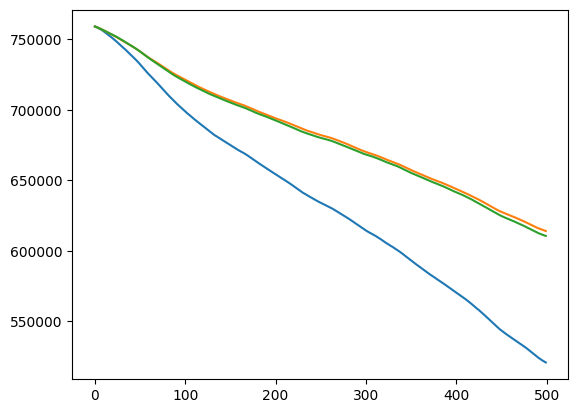

In [7]:
plt.plot(df.SOC1)
plt.plot(df.SOC2)
plt.plot(df.SOC3)